In [1]:
#! jupyter notebook list

****
# Model Building and Algorithms
****
`This notebook consist of the final data visualisation and model building`

***** 
Author: Ridwan Amokun (Data Scientist) |
[LinkedIn](https://www.linkedin.com/in/ridwan-amokun/) |
[Medium](https://medium.com/@amokunridwan) |
[Twitter](https://twitter.com/Markyrrh) |
[GitHub](https://www.github.com/MITXy)
*****

In [2]:
import random
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import joblib
from rid_utils import show_distribution
from nba_model import *

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use("ggplot")
pd.set_option("display.max_columns", None)
rid_seed = 12

from rid_utils import show_distribution
import xgboost
import catboost
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, KFold
#from sklearn.tree import RandomForestRegressor, RandomForestClassifier, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

***
># Data Evaluation
***

In [3]:
data = pd.read_csv(pathX, index_col=[0])
data.head()

,team,Alias,Conference,score1,score2,win,loss,win_prob_avg,win_rate,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,3P%,FT
0,Hawks,ATL,E,116.976190,114.490476,122,88,0.629218,64.076048,1496.545705,1519.673885,0.599060,0.400940,1495.912907,1520.306683,1521.298257,1495.274109,0.640760,0.359240,793.0,2672.0,3465.0,1956.0,544.0,335.0,874.0,1453.0,8834.0,5.597,1394.0
1,Celtics,BOS,E,115.245833,108.204167,160,80,0.459653,74.102324,1629.144872,1517.390745,0.748987,0.251013,1627.500510,1519.035108,1642.167855,1519.042152,0.741023,0.258977,710.0,2415.0,3125.0,1609.0,464.0,397.0,852.0,1151.0,7286.0,4.225,1092.0
2,Nets,BRK,E,112.886256,110.654028,121,90,0.470244,62.254188,1534.971517,1512.854275,0.650805,0.349195,1532.733495,1515.092297,1519.269027,1500.640490,0.622542,0.377458,615.0,2005.0,2620.0,1329.0,406.0,341.0,708.0,1208.0,7043.0,4.060,1011.0
3,Bulls,CHI,E,111.579487,110.712821,100,95,0.510336,55.323480,1469.032866,1511.286566,0.574517,0.425483,1467.443871,1512.875560,1460.233095,1503.130909,0.553235,0.446765,645.0,2652.0,3297.0,1929.0,567.0,327.0,970.0,1469.0,8937.0,5.266,1399.0
4,Hornets,CHO,E,109.173684,112.731579,76,114,0.481449,49.077552,1445.200474,1504.790798,0.552041,0.447959,1440.972582,1509.018690,1397.798650,1493.135932,0.490776,0.509224,818.0,2632.0,3450.0,2131.0,668.0,377.0,973.0,1523.0,8855.0,4.065,1207.0


In [4]:
data.describe()

,score1,score2,win,loss,win_prob_avg,win_rate,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,3P%,FT
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,113.539843,111.637860,117.466667,91.766667,0.500136,60.261752,1509.811982,1512.792874,0.617023,0.382977,1508.138118,1514.466738,1500.578544,1500.828302,0.602618,0.397382,735.166667,2443.700000,3178.866667,1749.666667,545.833333,337.766667,927.666667,1394.833333,7978.433333,4.736200,1216.766667
std,2.476003,2.937794,30.970212,19.329597,0.080259,9.487814,69.400017,6.578305,0.081900,0.081900,70.005347,6.158511,81.570516,10.072456,0.094878,0.094878,158.812638,401.919116,522.198914,334.256904,114.868466,64.418183,158.800967,220.857589,1219.794717,0.844201,185.002830
min,108.895833,107.435685,55.000000,59.000000,0.334512,39.770827,1365.128557,1500.210421,0.443881,0.251013,1362.044399,1502.075888,1318.514590,1488.035611,0.397708,0.258977,440.000000,1271.000000,1784.000000,830.000000,287.000000,201.000000,505.000000,835.000000,4416.000000,3.428000,669.000000
25%,111.832674,109.369008,96.000000,80.250000,0.448832,54.273506,1466.395058,1509.008244,0.569605,0.318246,1463.525685,1510.933165,1450.065481,1492.846282,0.542735,0.322915,646.000000,2243.500000,2993.250000,1626.500000,498.000000,295.500000,829.750000,1247.250000,7428.500000,4.105000,1101.750000
50%,113.639168,110.771459,117.000000,90.000000,0.510985,61.267835,1502.161963,1512.418796,0.609802,0.390198,1501.302113,1515.069188,1514.802304,1499.601300,0.612678,0.387322,723.000000,2588.500000,3307.000000,1793.000000,543.500000,332.500000,962.500000,1464.500000,8439.000000,4.581500,1265.500000
75%,115.315246,113.727018,144.750000,103.750000,0.555480,67.708509,1559.480847,1517.319833,0.681754,0.430395,1559.162797,1518.834194,1560.779486,1504.155529,0.677085,0.457265,813.250000,2710.000000,3553.250000,1949.250000,601.000000,375.500000,1040.750000,1533.500000,8849.750000,5.329250,1340.500000
max,118.094170,117.371287,170.000000,137.000000,0.657109,74.102324,1629.144872,1526.068407,0.748987,0.556119,1627.500510,1527.252462,1642.167855,1523.306603,0.741023,0.602292,1158.000000,2924.000000,4030.000000,2220.000000,800.000000,533.000000,1173.000000,1777.000000,9480.000000,7.069000,1471.000000


In [5]:
data.corr()

,score1,score2,win,loss,win_prob_avg,win_rate,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,raptor1_pre,raptor2_pre,raptor_prob1,raptor_prob2,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,3P%,FT
score1,1.000000,0.141415,0.524556,-0.575741,0.222895,0.580865,0.542265,0.284014,0.531847,-0.531847,0.544305,0.226881,0.560445,0.187619,0.580865,-0.580865,-0.139904,-0.152971,-0.160285,-0.190516,-0.151708,-0.066049,-0.297433,-0.357286,-0.145823,-0.192995,-0.143593
score2,0.141415,1.000000,-0.715718,0.676830,0.128409,-0.634442,-0.703581,-0.212889,-0.706947,0.706947,-0.705799,-0.133040,-0.654228,-0.419721,-0.634442,0.634442,-0.303876,-0.495969,-0.474146,-0.428973,-0.438289,-0.271651,-0.332518,-0.390204,-0.509826,-0.108251,-0.500541
win,0.524556,-0.715718,1.000000,-0.946553,0.014204,0.897944,0.950327,0.480842,0.932035,-0.932035,0.953429,0.384948,0.919890,0.623077,0.897944,-0.897944,0.060488,0.318314,0.263391,0.273336,0.232887,0.084231,0.122108,0.098323,0.328587,0.019123,0.309280
loss,-0.575741,0.676830,-0.946553,1.000000,-0.066799,-0.896282,-0.925182,-0.314996,-0.929799,0.929799,-0.928587,-0.206824,-0.885030,-0.406594,-0.896282,0.896282,-0.126054,-0.321369,-0.285683,-0.245478,-0.266377,-0.149172,-0.067620,-0.078271,-0.341908,0.053567,-0.330733
win_prob_avg,0.222895,0.128409,0.014204,-0.066799,1.000000,-0.072263,-0.032948,0.001482,-0.034780,0.034780,-0.030253,-0.025809,-0.070224,-0.100664,-0.072263,0.072263,0.196222,0.131006,0.160507,0.191095,0.169506,-0.147886,0.097242,-0.014202,0.089938,0.113933,-0.107225
win_rate,0.580865,-0.634442,0.897944,-0.896282,-0.072263,1.000000,0.958302,0.365880,0.956378,-0.956378,0.958302,0.296631,0.986315,0.391890,1.000000,-1.000000,0.040631,0.162114,0.137130,0.123834,0.124023,0.039398,-0.075493,-0.018364,0.216987,-0.168158,0.228037
elo1_pre,0.542265,-0.703581,0.950327,-0.925182,-0.032948,0.958302,1.000000,0.382806,0.993435,-0.993435,0.999914,0.311582,0.969125,0.511365,0.958302,-0.958302,0.053921,0.204421,0.173734,0.149068,0.159604,0.061883,-0.034825,-0.018560,0.232541,-0.148683,0.206028
elo2_pre,0.284014,-0.212889,0.480842,-0.314996,0.001482,0.365880,0.382806,1.000000,0.288326,-0.288326,0.386603,0.987378,0.436874,0.672051,0.365880,-0.365880,-0.084302,0.082362,0.037753,0.172439,0.100290,-0.123148,0.102661,0.088663,0.106818,0.234795,0.137914
elo_prob1,0.531847,-0.706947,0.932035,-0.929799,-0.034780,0.956378,0.993435,0.288326,1.000000,-1.000000,0.993038,0.214853,0.958701,0.455218,0.956378,-0.956378,0.067710,0.201095,0.175368,0.137332,0.156660,0.079505,-0.056595,-0.023250,0.229877,-0.175235,0.201443
elo_prob2,-0.531847,0.706947,-0.932035,0.929799,0.034780,-0.956378,-0.993435,-0.288326,-1.000000,1.000000,-0.993038,-0.214853,-0.958701,-0.455218,-0.956378,0.956378,-0.067710,-0.201095,-0.175368,-0.137332,-0.156660,-0.079505,0.056595,0.023250,-0.229877,0.175235,-0.201443


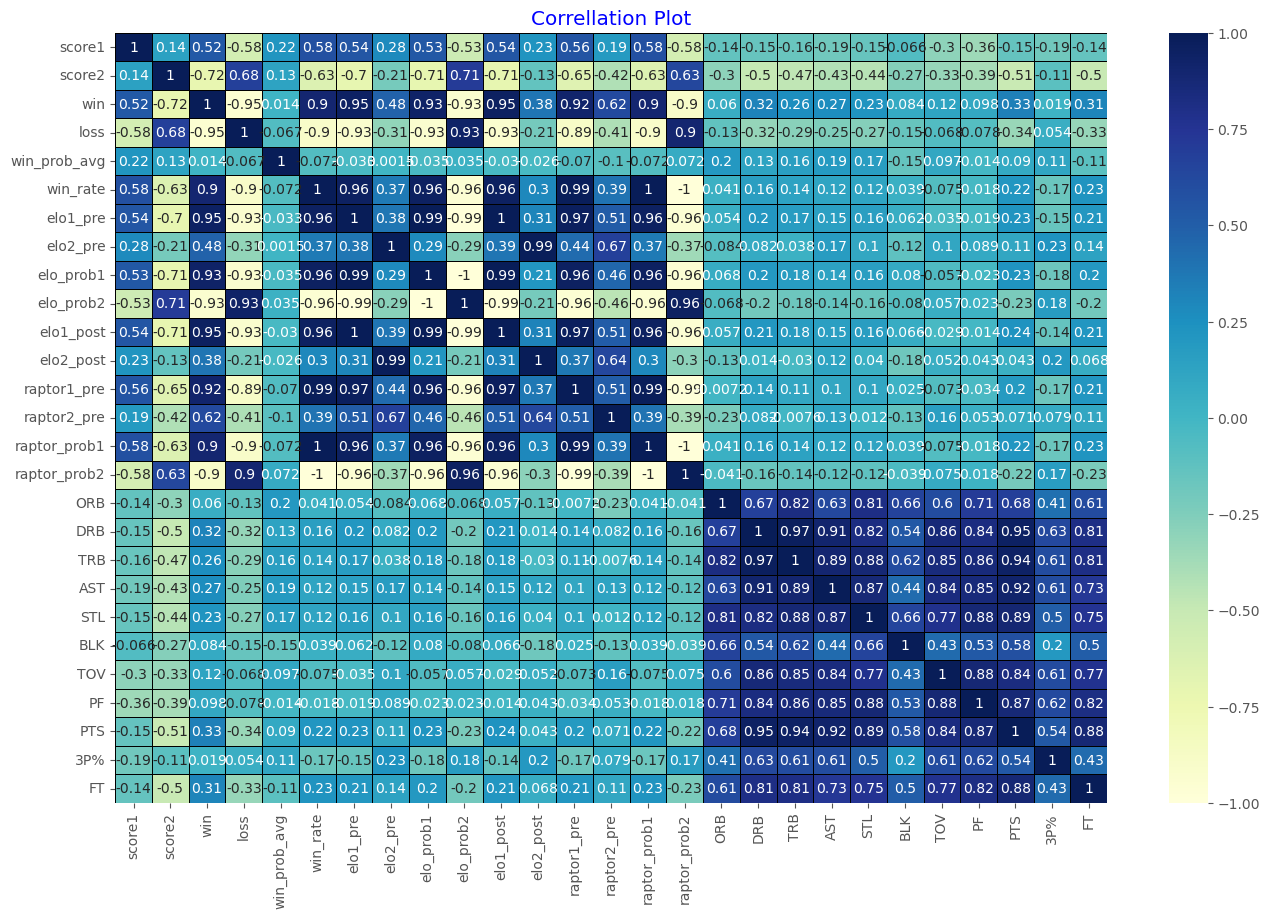

In [6]:
# plot the data correllation
plot_heatmap(data.corr())

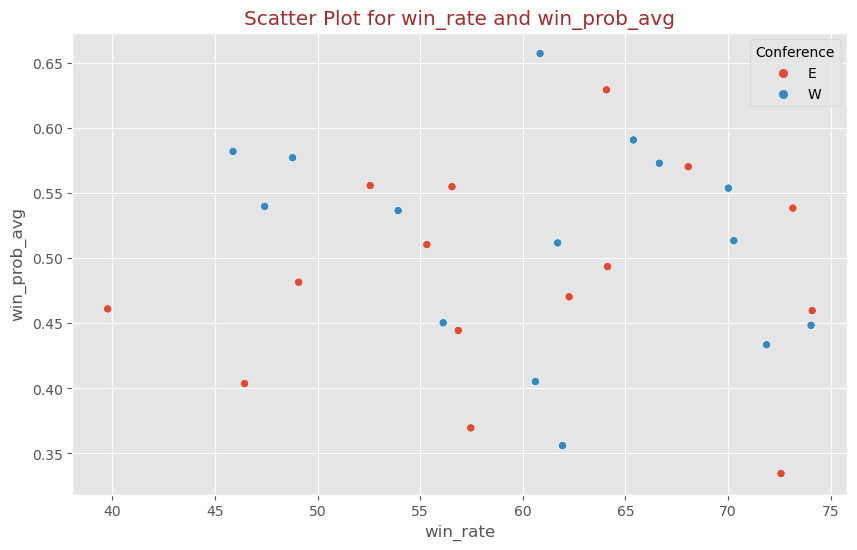

In [7]:
# plot dotplot    
plot_dotplot("win_rate", "win_prob_avg", data)

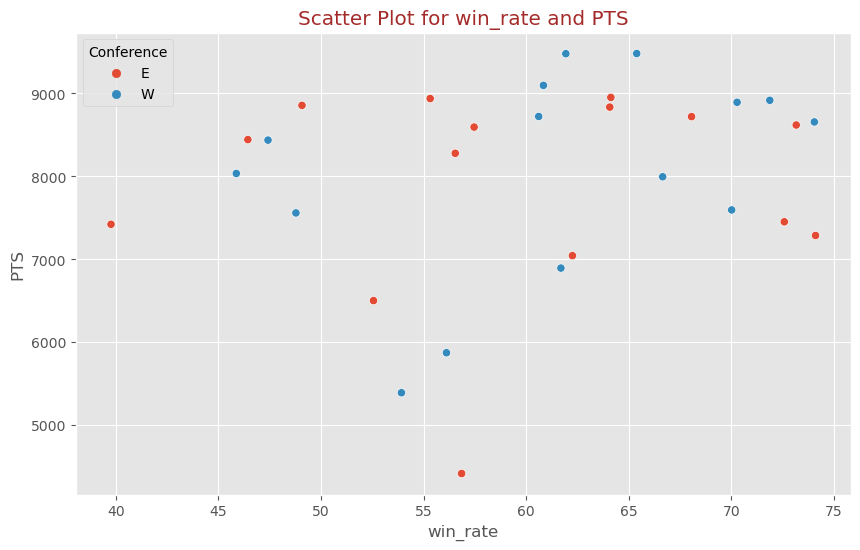

In [8]:
plot_dotplot("win_rate", "PTS", data)

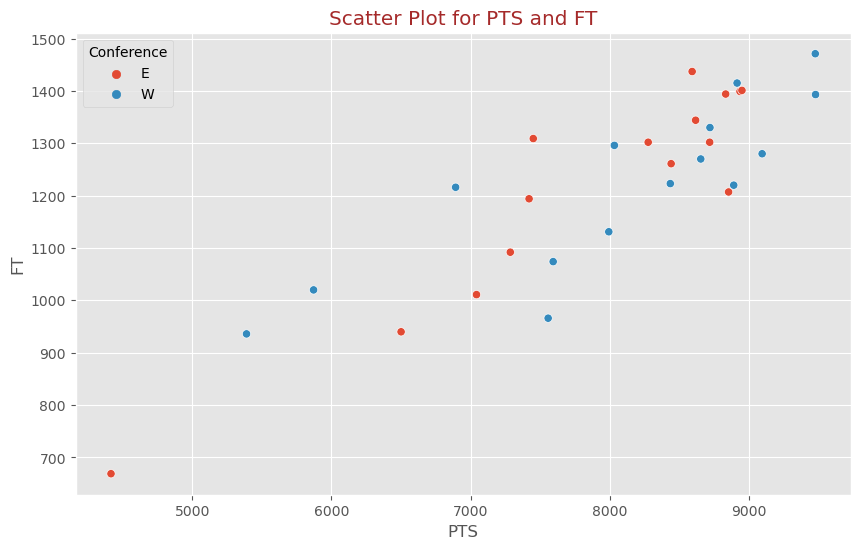

In [9]:
plot_dotplot("PTS", "FT", data)

***
># Feature Importances
***
`Here we run a simple model on the data available to identify potential important features`

In [10]:
rid_seed = 12
X = data.drop(columns=["PTS", "DRB", "team", "Alias", "Conference"])
y = data["win_rate"]

X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=rid_seed)
    
rfr = RandomForestRegressor(random_state=rid_seed, max_depth=100)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
mae_rfr = mean_absolute_error(y_test, y_pred)
print(f"The Mean Absolute Error with a Random Forest Model is {mae_rfr}")

The Mean Absolute Error with a Random Forest Model is 1.5793123943971814


In [11]:
rfr_feature_score = rfr.feature_importances_
rfr_feature_names = X.columns
feature_importance = pd.DataFrame({"Features":rfr_feature_names, "Feature Score": rfr_feature_score}).set_index("Features")
feature_importance = feature_importance.sort_values(by="Feature Score", ascending=True)
feature_importance.head(10)

,Feature Score
Features,
score2,0.000781
TRB,0.001464
score1,0.001767
TOV,0.001856
STL,0.002046
elo2_pre,0.002850
FT,0.002947
raptor2_pre,0.002994
PF,0.003018


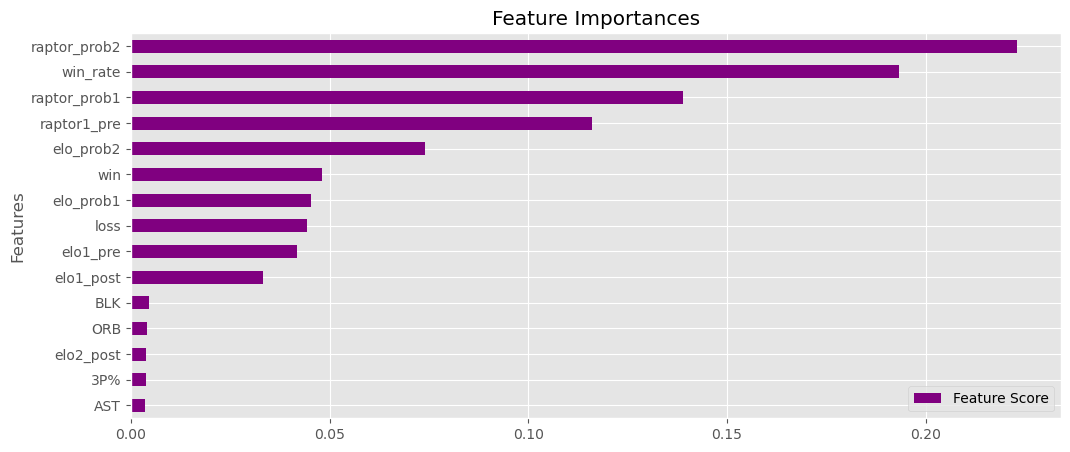

In [12]:
feature_importance.tail(15).plot(kind="barh", figsize=(12,5), color="purple")
plt.title("Feature Importances", color="black")
plt.show()

The statistical values are as follows:
 Minimum value:39.77
 Maximum value: 74.10
 Mode: 39.77 
 Mean: 60.26 
 Standard Deviation: 9.49 
 Variance: 3.08 
 Median: 61.27


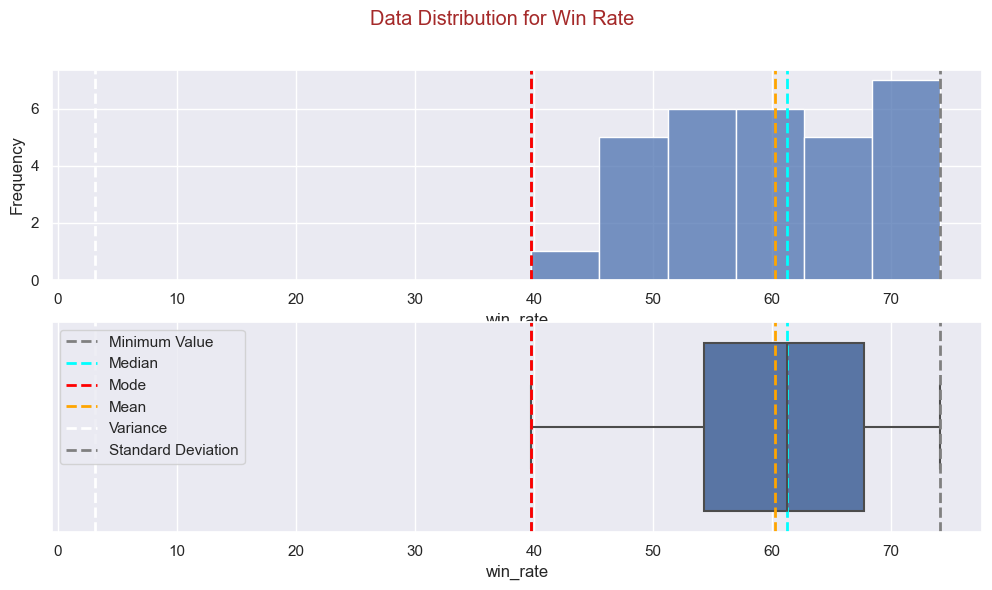

In [13]:
# get the distribution of win rate
show_distribution(data["win_rate"], "Win Rate")

***
># Model Building
***

In [14]:
model_linear, mae_linear, y_pred_linear = build_model(data, "linear1")
model_tree, mae_tree, y_pred_tree = build_model(data)

joblib.dump(model_linear, pathY)

['C:/Users/DELL/Project/FreeWorks/NBA  Project/model.joblib']

>>### NBA Algorithm
`The algo predict function helps to rank the data based on their wining rate for each of the Conference. The Eastern and Western Conference both have 10 teams qualifying for the Play-Offs`

In [15]:
western_playoff = algo_predict(data, team_only_performance="prob", all=True)[1]
eastern_playoff = algo_predict(data, team_only_performance="prob", all=True)[0]
western = algo_predict(data, team_only_performance="prob", all=True)[3]
eastern = algo_predict(data, team_only_performance="prob", all=True)[2]

In [16]:
western

,team,win_prob,points,win_rate,conf,predictions
7,Nuggets,0.448348,8655.0,74.043977,W,72.824504
28,Jazz,0.433414,8916.0,71.873734,W,71.366831
23,Suns,0.513355,8892.0,70.279132,W,70.022182
6,Mavericks,0.553692,7594.0,70.015280,W,69.541670
12,Clippers,0.572873,7994.0,66.652070,W,66.499585
14,Grizzlies,0.590714,9480.0,65.387566,W,65.789677
18,Pelicans,0.511635,6893.0,61.694357,W,61.520165
17,Timberwolves,0.355977,9478.0,61.934356,W,61.334602
9,Warriors,0.657109,9096.0,60.841312,W,61.196371
13,Lakers,0.405173,8721.0,60.611889,W,60.881286


In [17]:
eastern

,team,win_prob,points,win_rate,conf,predictions
1,Celtics,0.459653,7286.0,74.102324,E,74.039545
16,Bucks,0.538374,8618.0,73.160013,E,73.562583
22,76ers,0.334512,7451.0,72.580167,E,72.539541
27,Raptors,0.570192,8719.0,68.060655,E,67.860888
15,Heat,0.493439,8951.0,64.128048,E,64.136298
0,Hawks,0.629218,8834.0,64.076048,E,63.528990
2,Nets,0.470244,7043.0,62.254188,E,62.318069
19,Knicks,0.369582,8593.0,57.463805,E,57.621555
11,Pacers,0.444352,4416.0,56.854711,E,56.702504
5,Cavaliers,0.554787,8277.0,56.545809,E,56.660341


****
# Conclusion
****
The algorithm used here are just for test and simulation. It is worthy of note that it might be difficult to scale. <br>
`The NBA RAPTOR proved to be a very important feature in identifying the win rate of each team`